# 03. 機器學習 (XGBoost & SHAP)

**目的**：捕捉傳染病數據中的非線性關係與交互作用，並透過 SHAP 值找出關鍵預測因子。
**內容**：
*   **特徵工程**：建立 Lags (滯後), Rolling Means (移動平均), Day of Week (星期幾) 等時間序列特徵。
*   **模型訓練**：使用 XGBoost Regressor 預測本土病例數。
*   **模型解釋**：計算 SHAP 值 (SHapley Additive exPlanations) 以評估特徵重要性。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 定義路徑
raw_data_dir = "../data/raw"
processed_data_dir = "../data/processed"
file_case = os.path.join(raw_data_dir, "Age_County_Gender_day_19CoV.csv")

c:\Users\flash\.conda\envs\sklearn311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 資料準備與聚合
同樣先將資料處理為「每日全台本土病例數」的時間序列格式。

In [2]:
try:
    df = pd.read_csv(file_case)
    df['發病日'] = pd.to_datetime(df['發病日'])
    
    # 1. 聚合全台每日本土病例
    df_local = df[df['是否為境外移入'] == 0].groupby('發病日')['確定病例數'].sum().reset_index(name='local_cases')
    
    # 2. 聚合全台每日境外病例
    df_imported = df[df['是否為境外移入'] == 1].groupby('發病日')['確定病例數'].sum().reset_index(name='imported_cases')
    
    # 3. 確保日期連續
    min_date = min(df['發病日'].min(), df_local['發病日'].min())
    max_date = max(df['發病日'].max(), df_local['發病日'].max())
    all_dates = pd.date_range(min_date, max_date, freq='D')
    
    model_data = pd.DataFrame({'Date': all_dates})
    model_data = model_data.merge(df_local, left_on='Date', right_on='發病日', how='left').fillna(0)
    model_data = model_data.merge(df_imported, left_on='Date', right_on='發病日', how='left').fillna(0)
    model_data = model_data[['Date', 'local_cases', 'imported_cases']]
    
    print(f"Data Range: {min_date.date()} to {max_date.date()}")
    display(model_data.tail())
    
except FileNotFoundError:
    print("Data file not found.")

Data Range: 2020-01-11 to 2023-12-26


,Date,local_cases,imported_cases
1441,2023-12-22,4.0,0.0
1442,2023-12-23,0.0,0.0
1443,2023-12-24,0.0,0.0
1444,2023-12-25,0.0,0.0
1445,2023-12-26,4.0,0.0


## 2. 特徵工程 (Feature Engineering)
為了讓 XGBoost 學習時間依賴性，我們需要手動建立特徵：
*   **Lags (滯後)**: 過去 1, 3, 7, 14 天的病例數。
*   **Rolling Means (移動平均)**: 過去 7, 14 天的平均病例數 (反映趨勢)。
*   **Calendar Features**: Day of week, Month (反映週期性與季節性)。

In [3]:
if 'model_data' in locals():
    data = model_data.copy()
    
    # Target: local_cases
    
    # 1. Lags
    for lag in [1, 2, 3, 7, 10, 14, 21]:
        data[f'local_lag_{lag}'] = data['local_cases'].shift(lag)
        data[f'imported_lag_{lag}'] = data['imported_cases'].shift(lag)
        
    # 2. Rolling Statistics (基於 Lag 1 避免 Data Leakage)
    for window in [7, 14]:
        data[f'local_roll_mean_{window}'] = data['local_cases'].shift(1).rolling(window=window).mean()
        data[f'local_roll_std_{window}'] = data['local_cases'].shift(1).rolling(window=window).std()
        
    # 3. Calendar Features
    data['day_of_week'] = data['Date'].dt.dayofweek
    data['month'] = data['Date'].dt.month
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # 移除 NaN
    data_clean = data.dropna().reset_index(drop=True)
    
    print(f"Shape after FE: {data_clean.shape}")
    display(data_clean.head())

Shape after FE: (1425, 24)


,Date,local_cases,imported_cases,local_lag_1,imported_lag_1,local_lag_2,imported_lag_2,local_lag_3,imported_lag_3,local_lag_7,...,imported_lag_14,local_lag_21,imported_lag_21,local_roll_mean_7,local_roll_std_7,local_roll_mean_14,local_roll_std_14,day_of_week,month,is_weekend
0,2020-02-01,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.000000,0.816497,0.571429,0.755929,5,2,1
1,2020-02-02,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.000000,0.816497,0.571429,0.755929,6,2,1
2,2020-02-03,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,...,1.0,0.0,0.0,0.857143,0.899735,0.571429,0.755929,0,2,0
3,2020-02-04,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,...,1.0,0.0,0.0,0.714286,0.755929,0.642857,0.744946,1,2,0
4,2020-02-05,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.428571,0.534522,0.642857,0.744946,2,2,0


## 3. 模型訓練 (Time Series Split)
使用時間序列切分：
*   **Train**: 前 80% 時間
*   **Test**: 後 20% 時間
避免使用隨機切分 (Random Split) 造成未來數據洩漏 (Data Leakage)。

In [4]:
if 'data_clean' in locals():
    # 定義特徵與目標
    features = [col for col in data_clean.columns if col not in ['Date', 'local_cases', 'imported_cases']]
    target = 'local_cases'
    
    # Time Series Split
    split_idx = int(len(data_clean) * 0.8)
    train = data_clean.iloc[:split_idx]
    test = data_clean.iloc[split_idx:]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # XGBoost Parameters
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample=0.8,
        early_stopping_rounds=50,
        random_state=42,
        n_jobs=-1
    )
    
    # Training
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    
    # Prediction
    preds = model.predict(X_test)
    
    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"\nTest RMSE: {rmse:.2f}")

[0]	validation_0-rmse:17367.26799	validation_1-rmse:8981.60657
[100]	validation_0-rmse:416.20145	validation_1-rmse:1278.30369


c:\Users\flash\.conda\envs\sklearn311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:36:30] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "colsample" } are not used.

  warnings.warn(smsg, UserWarning)


[185]	validation_0-rmse:105.84097	validation_1-rmse:1285.54121

Test RMSE: 1274.31


## 4. 結果視覺化 (Predictions)

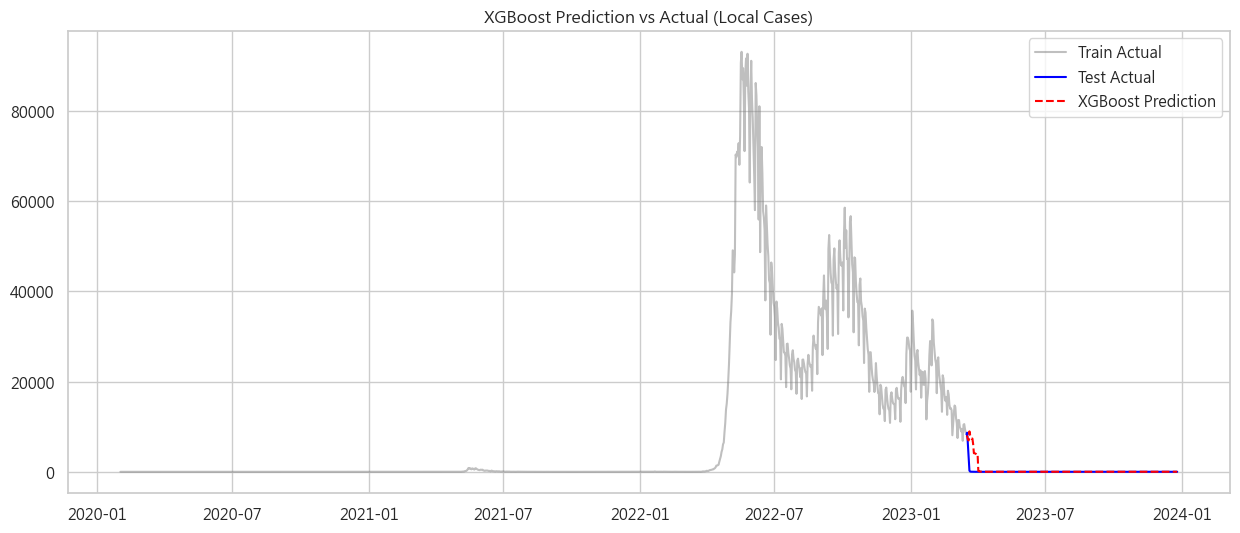

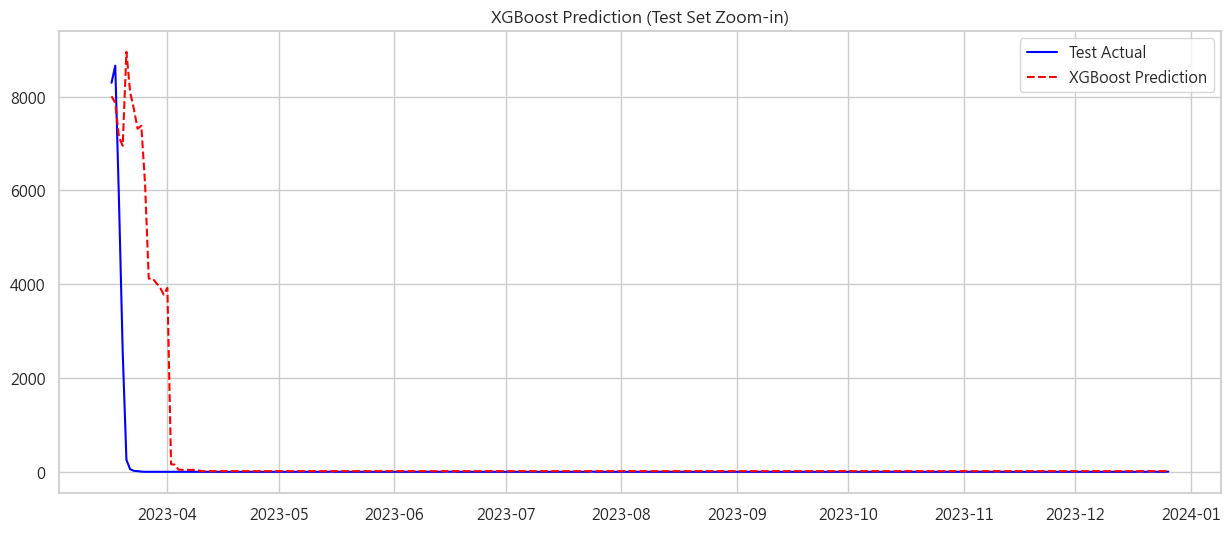

In [5]:
if 'model' in locals():
    plt.figure(figsize=(15, 6))
    
    # Plot Train
    plt.plot(train['Date'], train[target], label='Train Actual', color='gray', alpha=0.5)
    
    # Plot Test Actual
    plt.plot(test['Date'], test[target], label='Test Actual', color='blue')
    
    # Plot Test Pred
    plt.plot(test['Date'], preds, label='XGBoost Prediction', color='red', linestyle='--')
    
    plt.title('XGBoost Prediction vs Actual (Local Cases)')
    plt.legend()
    plt.show()
    
    # Zoom in to Test set
    plt.figure(figsize=(15, 6))
    plt.plot(test['Date'], test[target], label='Test Actual', color='blue')
    plt.plot(test['Date'], preds, label='XGBoost Prediction', color='red', linestyle='--')
    plt.title('XGBoost Prediction (Test Set Zoom-in)')
    plt.legend()
    plt.show()

## 5. SHAP Feature Importance
找出哪些變數對預測本土病例最重要 (例如：是7天前的本土病例數，還是14天前的境外移入？)。

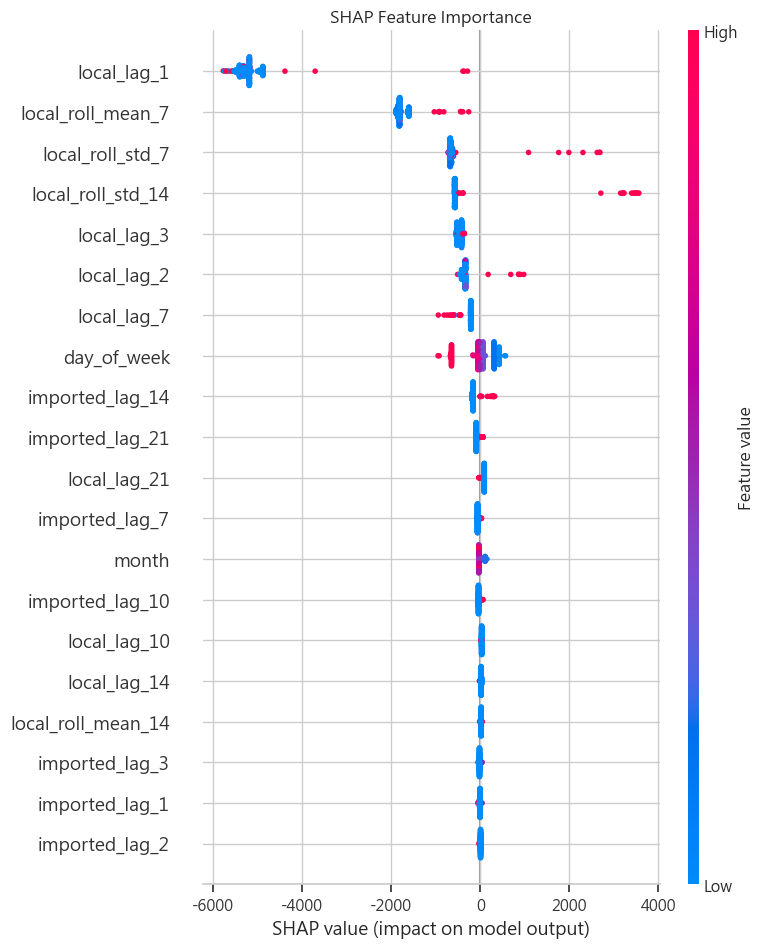

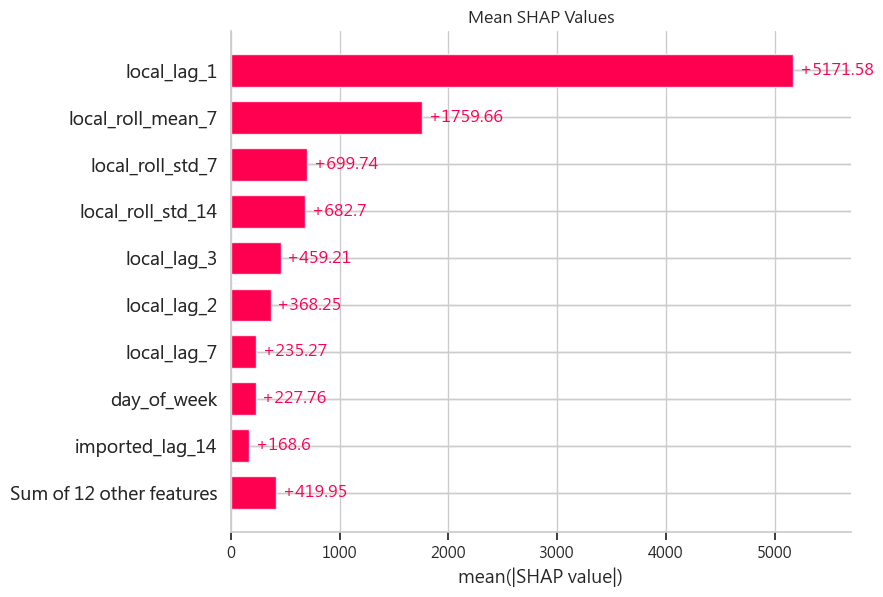

In [6]:
if 'model' in locals():
    # 使用 TreeExplainer 針對樹模型優化
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)
    
    # Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title("SHAP Feature Importance")
    plt.show()
    
    # Bar Plot (Mean absolute SHAP value)
    plt.figure(figsize=(10, 8))
    shap.plots.bar(shap_values, show=False)
    plt.title("Mean SHAP Values")
    plt.show()